<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center>Introduction to Anomaly Detection in Time Series with Keras</h2>


## Task 1: Project Overview and Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.4.1


## Task 2: Load and Inspect the IBM Stock Data

Data Source: IBM Daily Prices 2009 - 2019

In [2]:
df = pd.read_csv('/content/IBM.csv', parse_dates=['Date'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-07-01,105.000000,106.269997,104.730003,104.839996,73.336884,5537300
1,2009-07-02,103.800003,103.910004,101.730003,101.730003,71.161407,7026700
2,2009-07-06,101.570000,102.230003,100.470001,101.650002,71.105453,6522500
3,2009-07-07,101.339996,101.959999,100.029999,100.190002,70.084152,6685600
4,2009-07-08,100.290001,101.169998,99.500000,100.680000,70.426910,7380800


In [3]:
df.shape

(2537, 7)

In [4]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                    mode='lines',
                    name='close'))
fig.update_layout(showlegend=True)
fig.show()

## Task 3: Data Preprocessing

In [5]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(2029, 7) (508, 7)


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

## Task 4: Create Training and Test Splits

In [7]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [8]:
time_steps = 30

X_train, y_train = create_dataset(train[['Close']], train.Close, time_steps)
X_test, y_test = create_dataset(test[['Close']], test.Close, time_steps)

print(X_train.shape)

(1999, 30, 1)


## Task 5: Build an LSTM Autoencoder

In [9]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))                 
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

## Task 6: Train the Autoencoder

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    callbacks = [es],
    shuffle=False
)

Epoch 1/10
57/57 [==============================] - 9s 104ms/step - loss: 0.5445 - val_loss: 0.1253
Epoch 2/10
57/57 [==============================] - 4s 79ms/step - loss: 0.1710 - val_loss: 0.1132
Epoch 3/10
57/57 [==============================] - 4s 79ms/step - loss: 0.1548 - val_loss: 0.0720
Epoch 4/10
57/57 [==============================] - 5s 80ms/step - loss: 0.1408 - val_loss: 0.0990
Epoch 5/10
57/57 [==============================] - 5s 81ms/step - loss: 0.1398 - val_loss: 0.0731
Epoch 6/10
57/57 [==============================] - 5s 81ms/step - loss: 0.1267 - val_loss: 0.0784


## Task 7: Plot Metrics and Evaluate the Model

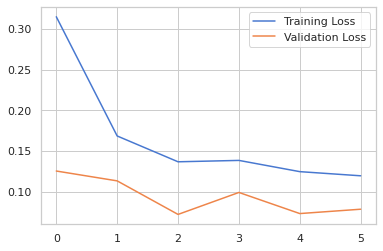

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [13]:
X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [14]:
model.evaluate(X_test, y_test)

15/15 [==============================] - 0s 22ms/step - loss: 0.1368


0.13684312999248505

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



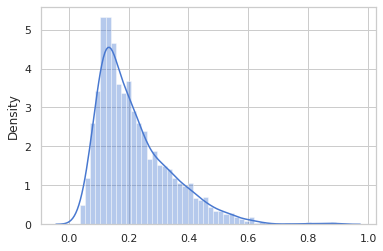

In [15]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [16]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



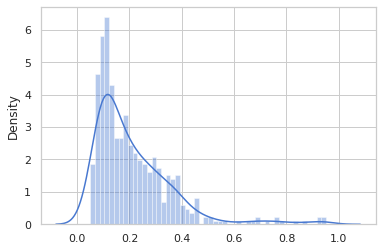

In [17]:
sns.distplot(test_mae_loss, bins=50, kde=True);

## Task 8: Detect Anomalies in the IBM Stock Data

In [18]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Close'] = test[time_steps:].Close

In [19]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].Date, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].Date, y=test_score_df.threshold,
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [20]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,Date,Open,High,Low,Close,Adj Close,Volume,loss,threshold,anomaly
2345,2018-10-23,129.020004,131.899994,128.410004,-1.325005,119.173058,6463600,0.690852,0.65,True
2346,2018-10-24,131.169998,131.690002,127.000000,-1.479539,115.540009,5710300,0.694206,0.65,True
2347,2018-10-25,127.250000,127.790001,125.139999,-1.508901,114.849724,10304300,0.731082,0.65,True
2348,2018-10-26,125.209999,125.779999,123.709999,-1.573032,113.342018,8767000,0.752760,0.65,True
2349,2018-10-29,119.339996,123.949997,118.300003,-1.771995,108.664467,20450400,0.775535,0.65,True


In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].Date, y=scaler.inverse_transform(test[time_steps:].Close),
                    mode='lines',
                    name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.Date, y=scaler.inverse_transform(anomalies.Close),
                    mode='markers',
                    name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()